In [ ]:
# ch09 02.ipynb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Embedding, Dense, SimpleRNN, LSTM, Bidirectional, Flatten, Dropout
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2, l1_l2

In [13]:
# 1 .데이터 로드
ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categoris = [movie_reviews.categories(id)[0] for id in ids]
# 토큰화 및 정수 인코딩
max_word = 10000
tokenizer = Tokenizer(num_words=max_word, oov_token='UNK')
tokenizer.fit_on_texts(reviews)
# 텍스트를 시퀀스로 변환
x = tokenizer.texts_to_sequences(reviews)
# 시퀀스 패딩
maxlen = 500
x = pad_sequences(x,maxlen=maxlen,truncating='pre')
# 레이블 변환
label_dict = {'pos':1, 'neg':0}
y = np.array([label_dict[c] for c in categoris])
# 학습 테스트 데이터 분할
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42,test_size=0.2)

In [15]:
# 2 .세가지 모델 구축 , 학습
# 시드고정(재현성)
np.random.seed(42)
tf.random.set_seed(42)
# 모델 성능
results = {}
# ------ model 1 baseline(Flatten + Dense)
model1 = Sequential([
    Embedding(max_word,32,input_length = maxlen),
    Flatten(),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['acc'])
history1 = model1.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)
score1 = model1.evaluate(x_test,y_test)
results['baseline'] = score1[1]
print(f'model1 정확도:{score1[1]:.4f}')

# ------ model 2 (SimpleRnn)
model2 = Sequential([
    Embedding(max_word,32,input_length = maxlen),
    SimpleRNN(32),
    Dense(32,activation='relu', kernal_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['acc'])
history2 = model2.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)
score1 = model2.evaluate(x_test,y_test)
results['Simple_RNN'] = score1[1]
print(f'model2 정확도:{score1[1]:.4f}')

# ------ model 3 (Bidirectional LSTM)
model3 = Sequential([
    Embedding(max_word,64,input_length = maxlen),
    Bidirectional(LSTM(64)),    
    Dense(64,activation='relu',kernal_regularizer=l2(0.01)),
    Dropout(0.5), # ^ Dropout 위치 ^
    Dense(1,activation='sigmoid')
])
model3.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['acc'])
history3 = model3.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)
score1 = model3.evaluate(x_test,y_test)
results['Bidirectional_LSTM'] = score1[1]
print(f'model3 정확도:{score1[1]:.4f}')

Epoch 1/10


c:\Users\Playdata2\miniconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.5164 - loss: 0.6931 - val_acc: 0.5281 - val_loss: 0.6906
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8977 - loss: 0.6252 - val_acc: 0.5312 - val_loss: 0.6877
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9586 - loss: 0.5402 - val_acc: 0.5500 - val_loss: 0.6802
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9852 - loss: 0.4250 - val_acc: 0.5813 - val_loss: 0.6723
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9961 - loss: 0.3020 - val_acc: 0.6062 - val_loss: 0.6628
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9984 - loss: 0.1990 - val_acc: 0.6031 - val_loss: 0.6545
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9992 - loss: 0.1316 - val_acc: 0.6125 - val_loss: 0.6472
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 1.0000 - loss: 0.0896 - val_acc: 0.6062 - val_loss: 0.6439
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 1.0000 - loss: 0.0619 -

ValueError: Unrecognized keyword arguments passed to Dense: {'kernal_regularizer': <keras.src.regularizers.regularizers.L2 object at 0x00000223DED67250>}

Bidirectional_LSTM : 0.7150
baseline : 0.6150
Simple_RNN : 0.4975


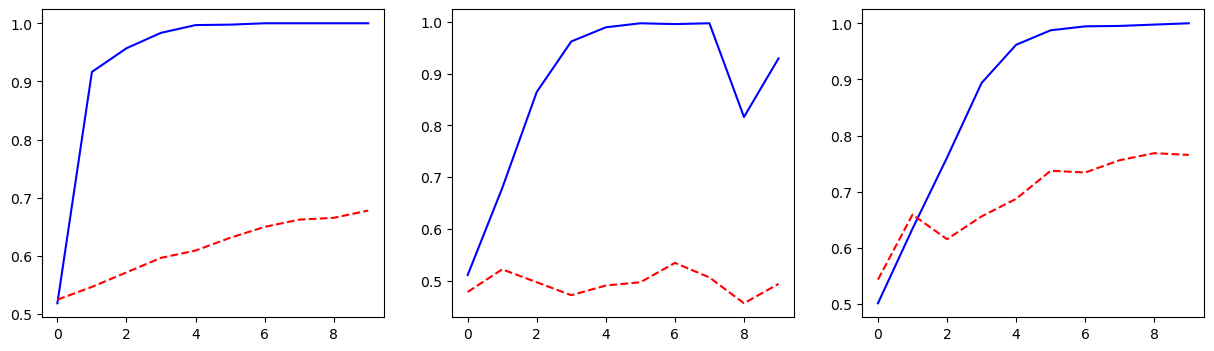

In [10]:
# 3. 성능 비교 및 시각화
for modelname, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f'{modelname} : {acc:.4f}')

fig, ax = plt.subplots(1,3,figsize=(15,4))
# baseline
ax[0].plot(history1.history['acc'], 'b-', label='train acc')
ax[0].plot(history1.history['val_acc'], 'r--', label='validation acc')
# SimpleRnn
ax[1].plot(history2.history['acc'], 'b-', label='train acc')
ax[1].plot(history2.history['val_acc'], 'r--', label='validation acc')
# Bidirectional LSTM
ax[2].plot(history3.history['acc'], 'b-', label='train acc')
ax[2].plot(history3.history['val_acc'], 'r--', label='validation acc')

# 과적합이 발생 Dropout과 정규화 진행

In [ ]:
# 4. 예측 결과 분석